# Dynamic Programming project

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
from scipy.optimize import fminbound
from plot_functions import plot_graph
from torchsummary import summary

Consider an agent who allocates her time between producing the consumption good and accumulating human capital.
The agent seeks to maximize her discounted utility, as captured by the following objective:

$$
\max_{\{C_t\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^t \, U(C_t)
$$

subject to:

$$ (i)\quad C_t = H_t^\alpha \, L_t, $$
$$ (ii)\quad H_t = (1 - \delta) H_{t-1} + (1 - L_{t-1}), $$
$$ (iii)\quad L_t \in [0,1]. $$


# 1. Approximation of the value function

$$
V(H_t) = \max_{L_t \in [0,1]} [ U(C_t) + \beta V(H_{t+1})] \\
$$

In [129]:

def utility(c, sigma=0.9):
    if sigma!=1:
        if c>=0:
            return (c**(1 - sigma)) / (1 - sigma)
        else:
            return -np.inf
    else:
        return np.log(c)

def consumption(H,L,alpha=0.4):
    return (H**alpha) * L

def human_capital_accumulation(H,L,delta=0.05):
    return (1 - delta) * H + (1 - L)

def labor_supply(H,H_next, delta=0.05):
    return (1 - delta) * H + 1 - H_next

def bellman_equation(C, H_next, H_values, V, beta=0.9):
    return utility(C) + beta * np.interp(H_next, H_values, V)

def objective(L, H, V, H_values):
    C = consumption(H,L)
    H_next = human_capital_accumulation(H,L)
    value = bellman_equation(C, H_next, H_values, V)
    return - value

def compute_value_function(V, H_values, H_min=0.1, H_max=5.0):
    new_V = np.zeros_like(V)
    policy = np.zeros_like(V)

    for i, H in enumerate(H_values):
        L = fminbound(objective, 0, 1, args=(H, V, H_values))
        C = consumption(H,L)
        H_next = human_capital_accumulation(H,L)
        value = bellman_equation(C, H_next, H_values, V)
        new_V[i], policy[i] = value, H_next
    return new_V, policy

def value_function_iteration(tolerance=1e-4, max_iterations=500, H_min=1e-2, H_max=5, H_points=200):
    """
    Approximates the value function of the agent
    """
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)

    for iteration in range(max_iterations):
        new_V, policy = compute_value_function(V, H_values)

        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration} iterations")
            break
        V = new_V
    return V, policy

In [130]:
V, optimal_policy = value_function_iteration()

Converged in 110 iterations


# 2. Graphics

## 2.1 Value function

In [131]:
H_min, H_max, H_points = 1e-2, 5, 200
H_values = np.linspace(H_min, H_max, H_points)

plot_graph(
    variable1 = (H_values, V, "approximated value function"),
    xaxis_title='Human Capital (H)',
    yaxis_title='Value Function',
    title="Approximation of the Value Function<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>"
)

Each point of the value function represents the maximum lifetime utility the agent can achieve starting with a specific level of human capital. 

## 2.2 Policy function

The policy function is the relation between the Human Capital at time t+1 and a time t: 
$$
H_{t+1}(H_t)
$$

In [132]:
# optimal_H = human_capital_accumulation(H_values,optimal_policy)

plot_graph(
    variable1=(H_values, optimal_policy,"Human Capital accumulation"),
    variable2=(H_values, H_values, "45° line"),
    xaxis_title="Ht",
    yaxis_title="Ht+1",
    title="Optimal policy function Ht+1(Ht)",
    showlegend=True
)

## 2.3 Consumption C(H) and Labour Supply L(H)

In [133]:
optimal_L = labor_supply(H_values, optimal_policy)
optimal_C = consumption(H_values,optimal_L)

plot_graph(
    variable1=(H_values, optimal_L,"Labor Supply"),
    variable2=(H_values, optimal_C, "Consumption"),
    xaxis_title="Human Capital (H)",
    yaxis_title="",
    title="Consumption C(H) and Labour Supply L(H)",
    showlegend=True
)

## 2.5 Interpretation

For <b>low values of human capital</b>, the agent prioritizes investing time in human capital rather than spend too much time working with a low productivity: it is optimal for the agent to learn and become more skilled and productive in the future. 

For <b>high values of human capital</b> it is optimal for the agent to reduce the investment in human capital and spend most of his time producing. For level of human capital higher than 2.9, the agent should even stop learning new skill and profit from his high productivity by spending all his time producing the consumption good. 

Those results are explained by diminishing returns of human capital and the presence of a <b>steady state level of human capital</b>. In the simulations, the steady state is found at around 𝐻=2.2 at the intersection between the optimal policy and the 45° line. Agents adopting the optimal policy will tend to converge towards this steady state level: 
- For <b>levels of human capital below the steady state</b>, the agent increases his lifetime utility by investing in human capital, as the returns to learning outweigh the opportunity cost of forgone production.
- For <b>levels of human capital above the steady state</b>, the agent can increase his lifetime utility by producing and consuming more. He thus reduces his investment in human capital which will depreciate until reaching the steady state level.  

# 3. Compute the value function associated to any arbitrary policy

## 3.1 Arbitrary policy for labor allocation

In this section, we will study the policies of labor allocation specifing the agent's choice of labor allocation (Lt) for a given level of human capital (Ht). It refers to the relation between the control variable and the state variable:
$$
L_t(H_t)
$$

Lets study the following arbitrary policy function: 
1. <b>Constant policy</b>: the agent allocate a constant fraction of its time to consumption production
$$
L_t(H_t) = c , \quad c \in [0,1]
$$
2. <b>Random policy</b>: the agent allocates labor randomly following a uniform law 
$$
L_t(H_t)∼U(0,1)
$$
3. <b>Proportional policy</b>: the agent allocates its time to consumption production proportionally to its human capital
$$
L_t(H_t) = \frac{H_t}{H_{max}}
$$

In [134]:
def constant_labor_policy(H, c=0.5):
    return np.full_like(H, c)

def random_labor_policy(H):
    np.random.seed(42)
    return np.random.uniform(0, 1, size=H.shape)

def proportional_labor_policy(H, H_max=5.0):
    if isinstance(H, (int, float)):
        return H / H_max
    return H / H_max

## 3.2 Approximate the value function for different labor allocation policies

In [135]:
def compute_value_function_with_arbitrary_policy(V, H_values, arbitrary_policy, alpha=0.4, delta=0.05, beta=0.9):
    """
    Evaluate the value function for a given lobor allocation policy.
    """
    new_V = np.zeros_like(V)
    for i, H in enumerate(H_values):
        L = arbitrary_policy[i]
        C = consumption(H, L, alpha)
        H_next = human_capital_accumulation(H, L, delta)
        new_V[i] = bellman_equation(C, H_next, H_values, V, beta)
    return new_V

def value_function_with_arbitrary_policy_iteration(arbitrary_policy, tolerance=1e-4, max_iterations=500, H_min=1e-2, H_max=5, H_points=200):
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)

    for iteration in range(max_iterations):
        new_V = compute_value_function_with_arbitrary_policy(V, H_values, arbitrary_policy)

        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration + 1} iterations")
            break
        V = new_V
    if iteration == (max_iterations-1):
        print(f'The value function iteration didn\'t converged after {max_iterations} iterations.')
    return V

In [136]:
# Compute the arbitrary policies of labor allocation
proportional_policy = proportional_labor_policy(H_values)
constant_policy = constant_labor_policy(H_values)
random_policy = random_labor_policy(H_values)

# Compute the value function associated to these policies
V_proportional = value_function_with_arbitrary_policy_iteration(arbitrary_policy=proportional_policy)
V_constant = value_function_with_arbitrary_policy_iteration(arbitrary_policy=constant_policy)
V_random = value_function_with_arbitrary_policy_iteration(arbitrary_policy=random_policy)

Converged in 111 iterations
Converged in 111 iterations
Converged in 111 iterations


In [137]:
plot_graph(
    variable1=(H_values, V,"Optimal policy"),
    variable2=(H_values, V_proportional,"Proportional L(Ht)"),
    variable3=(H_values, V_random, "Random L(Ht)"),
    variable4=(H_values, V_constant, "Constant L(Ht)"),
    xaxis_title="Ht",
    yaxis_title="Value function",
    title="Approximation of the Value Function for some different labor allocation policies<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

Warning: some arbitrary policies of labor supply can lead to levels of human capital higher than the upper bound (we set $H_{max} = 5$) as shown in the following graph of the policy function Ht+1(Ht). We could have penalize those infeasible values leading to other results.

In [138]:
H_constant = human_capital_accumulation(H_values,constant_policy)
H_random = human_capital_accumulation(H_values, random_policy)
H_proportional = human_capital_accumulation(H_values, proportional_policy)

plot_graph(
    variable1=(H_values, optimal_policy,"Optimal Policy"),
    # variable2=(H_values, H_values, "45° line"),
    variable3=(H_values, H_proportional,"Proportional Policy"),
    variable4=(H_values, H_random, "Random Policy"),
    variable5=(H_values, H_constant, "Constant Policy"),
    xaxis_title="Ht",
    yaxis_title="Ht+1",
    title="Policy function Ht+1(Ht) for different policies of labor supply allocation",
    showlegend=True
)

# 4. Implement a greedy procedure to update the policy function

## 4.1 Policy evaluation combined with a policy improvement procedure

In [139]:
def evaluate_and_improve_policy_function_until_convergence(tolerance=1e-4, max_iterations=500, H_min=1e-2, H_max=5.0, H_points=200, alpha=0.4, delta=0.05, beta=0.9):
    """
    Performs policy iteration using a greedy update of the policy function
    """
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)
    labor_policy = np.full(H_points, 0.5)  # Arbitrary constant initial policy L(H) = 0.5
    history = []

    for iteration in range(max_iterations):
        # Policy evaluation
        V_approx = compute_value_function_with_arbitrary_policy(V, H_values, labor_policy)
        # Policy improvment
        V_new, policy_new = compute_value_function(V_approx, H_values)
        labor_policy_new = labor_supply(H_values, policy_new)
        # Track value function evolution
        history.append(V_new)

        # if np.max(np.abs(labor_policy_new - labor_policy)) < tolerance:
        if np.max(np.abs(V_new - V_approx)) < tolerance:
            print(f"Converged in {iteration+1} iterations")
            break

        V = V_new
        labor_policy = labor_policy_new

    return V_new, labor_policy, history

In [140]:
V_improved, improved_policy, V_history = evaluate_and_improve_policy_function_until_convergence()

Converged in 56 iterations


In [141]:
plot_graph(
    variable1=(H_values, V, "Value function"),
    variable2=(H_values, V_improved, f"Value function at iteration {len(V_history)}"),
    variable3=(H_values, V_history[14], "Value function at iteration 15"),
    variable4=(H_values, V_history[19], "Value function at iteration 20"),
    variable5=(H_values, V_history[24], "Value function at iteration 25"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Value function",
    title="Value Function approximated with a greedy update of the policy function<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

## 4.2 Update the policy function with an ε-greedy strategy

The ε-greedy strategy balances exploration and exploitation by setting the parameter ε which controls how much the agent explores an arbitrary policy function instead of exploiting the optimal labor allocation. 


In [142]:
def compute_greedy_procedure_value_function(V, H_values, arbitrary_policy, epsilon = 0.1):
    """
    Computes the value function using a greedy policy update with an ε-greedy exploration strategy
    """
    new_V = np.zeros_like(V)
    policy = np.zeros_like(V)

    for i, H in enumerate(H_values):

        if np.random.rand() < epsilon: # Exploration
            L = arbitrary_policy[i]

        else: # Exploitation
            L = fminbound(objective, 0, 1, args=(H, V, H_values))

        C = consumption(H,L)
        H_next = human_capital_accumulation(H,L)
        value = bellman_equation(C, H_next, H_values, V)
        new_V[i], policy[i] = value, L

    return new_V, policy

def value_function_with_greedy_procedure_iteration(arbitrary_policy, tolerance=1e-2, max_iterations=500, H_min=1e-2, H_max=5, H_points=200):
    '''
    Performs policy iteration until convergence
    '''
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)
    epsilon = 0.1
    history = []

    for iteration in range(max_iterations):
        new_V, policy = compute_greedy_procedure_value_function(V, H_values, arbitrary_policy, epsilon=epsilon)
        # epsilon = max(0.01, epsilon - 0.005)
        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration+1} iterations")
            break
        V = new_V
        history.append(V)
    if iteration == (max_iterations-1):
        print(f'The value function iteration didn\'t converged after {max_iterations} iterations.')
    return V, policy, history

In [143]:
V_greedy, greedy_policy, history = value_function_with_greedy_procedure_iteration(
    arbitrary_policy=proportional_policy
)

The value function iteration didn't converged after 500 iterations.


In [144]:
plot_graph(
    variable1=(H_values, V, "Value function"),
    variable2=(H_values, V_greedy, f"Value function at iteration {len(history)}"),
    variable3=(H_values, history[19], "Value function at iteration 20"),
    variable4=(H_values, history[29], "Value function at iteration 30"),
    variable5=(H_values, history[49], "Value function at iteration 19"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Value function",
    title="Iteration of the value function with an ε-greedy procedure<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

In [145]:
plot_graph(
    variable1=(H_values, optimal_L, "Optimal labor allocation"),
    variable2=(H_values, greedy_policy, "With an ε-greedy procedure"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Labor Supply (L)",
    title="Labour allocation with and without an ε-greedy procedure <br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

# 5. Approximate the optimal path with a Neural Network

In this section, we aim to calibrate a neural network that approximates the path starting from an arbitrary initial stock of human capital and converging toward the steady state.  
To calibrate the neural network, we minimize the distance between the simulated and theoretical values of the:
- Euler equation, 
$$
\frac{U'(C_t)}{U'(C_{t+1})} = \beta \left( \alpha H_{t+1}^{\alpha - 1} \cdot L_{t+1} + H_{t+1}^{\alpha} L'_{1} \right) \cdot \frac{1}{H_t^\alpha}

$$
With 
$$
L_{t}(H_{t}, H_{t+1}) = 1 + (1-\delta)H_{t} - H_{t+1}
$$

Which is equivalent to write: 
$$
\frac{U'(C_t)}{U'(C_{t+1})} = \beta \left[ (1 + \alpha)(1 - \delta) H_{t+1}^\alpha + \alpha H_{t+1}^{\alpha - 1} (1 - H_{t+2}) \right] \cdot \frac{1}{H_t^\alpha}
$$
- Accumulation law of human capital

- Initial stock of human capital

<b>Slackness Condition in the Euler Equation </b>

Because $l_t$ must lie in $[0,1]$, the standard Euler equation only applies in the interior $(0,1)$.\\
At a boundary ($l_t = 0$ or $l_t = 1$), the usual first-order condition does not hold.
The lagrange multiplier associated with the inequality constraints $-l_t < 0 $ and $l_t - 1<0 $ for $t$ and $t+1$ should appear in the FOC. 

When $l_t$ is at a boundary, we add a penalty to the euler residual, equal to the difference between the bound and the value of $l_t$, that we <b>assume being equal to the lagrange multipliers associated to the inequality constraints</b>. This enforces the KKT condition. 

## 5.1 Define parameters and build the neural network structure

The network takes in a single input $t$ (time step) and outputs a vector of length 2:
$
(l_t, \, H_t) \;=\; \mathrm{NN}(t).
$

We apply a HardTanh activation function to the output $l_{t}$ so that $l_t$ exactly reaches 0 or 1 when needed, enforcing slackness condition when the boundary constraints bind. This is preferred to the sigmoid activation function where l_t never reach the bounds. We add also a final clamp to the human capital so that $h_t \in\;(0,H_{max})$ with $H_{max} = 5$. 

In [146]:
class Params:
    def __init__(self, alpha=0.4, delta=0.05, beta=0.9, sigma=0.9, h_0=1):
        self.alpha = alpha
        self.delta = delta
        self.beta = beta
        self.sigma = sigma
        self.h_0 = h_0

class Grid_data(d2l.HyperParameters):
    def __init__(self, max_T = 60, batch_size = 8):
        self.save_hyperparameters()
        self.time_range = torch.arange(0.0, self.max_T , 1.0)
        self.grid = self.time_range.unsqueeze(dim = 1)


class Data_label(Dataset):
    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

class NN(nn.Module, d2l.HyperParameters):
    def __init__(self, dim_hidden = 128, layers = 4, hidden_bias = True):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        # module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0
        self.q = nn.Sequential(*module)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Takes in input time step 'x' and outputs l_t and h_t:
        - l_t (labor supply), constrained to the range [0,1] using HardTanh
        - h_t (human capital), constrained to the range [0,5] using torch.clamp
        """
        out = self.q(x)
        # l = torch.sigmoid(out[:, 0:1])
        l = torch.nn.functional.hardtanh(out[:, 0:1], min_val=0.0, max_val=1.0)
        h = torch.clamp(out[:, 1:2], min=0.0, max=5.0)
        return torch.cat([l,h], dim=1)


class SS:
    """
    Computes the steady state of the model.
    """
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        self.h_ss = (self.alpha)/(1/self.beta + self.alpha*self.delta - 1 + self.delta)
        self.l_ss = 1-self.delta*self.h_ss
        self.c_ss = consumption(self.h_ss,self.l_ss)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def L(ct,ht,alpha):
    return ct/(ht**alpha)

def L_prime_Ht(delta):
    return (1 - delta)

def L_prime_Htp1():
    return -1

def u_prime(c, sigma=0.9):
    return c**(-sigma)

In [147]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )

q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

input_shape = (1, train_data.shape[-1])
summary(q_hat, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
              Tanh-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              Tanh-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              Tanh-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              Tanh-8                  [-1, 128]               0
            Linear-9                    [-1, 2]             258
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
---------------------------------------------

## 5.3 Train a neural network to approximate an optimal path

In [148]:
def neural_network_predictions(nn, time):
    """
    Retrieve the neural network predictions.
    """
    l_t = nn(time)[:, [0]]
    h_t = nn(time)[:, [1]]
    return l_t, h_t

def train_neural_network(params, train_data, optimizer, scheduler, initial_h, learning_rate=1e-3):
    """
    Train a neural network to approximate the optimal path.
    """

    q_hat = NN()
    optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

    alpha, delta, beta = params.alpha, params.delta, params.beta
    h_0 = initial_h
    num_epochs = 1000

    for epoch in range(num_epochs):
        for i, time in enumerate(train_data):
            time_zero = torch.zeros([1,1])

            h_t0 = q_hat(time_zero)[0,1]
            l_t, h_t = neural_network_predictions(q_hat, time)
            l_tp1, h_tp1 = neural_network_predictions(q_hat, time + 1)
            h_tp2 = neural_network_predictions(q_hat, time + 2)[1]

            c_t = consumption(h_t,l_t)
            c_tp1 = consumption(h_tp1,l_tp1)

            # Account for the slackness condition when the constraints l_t >= 0 or l_t <= 1 bind.
            # We choose to add the difference between l_t and the bound,
            # accounting for the lagrange multiplier associated to the constraints
            slack_penalty = torch.zeros_like(l_t)

            slack_penalty += torch.clamp(l_t - 1, min=0)
            slack_penalty += torch.clamp(-l_t, min=0)
            slack_penalty += torch.clamp(l_tp1 - 1, min=0)
            slack_penalty += torch.clamp(-l_tp1, min=0)

            # (i) Euler Equation
            res_euler = slack_penalty + ((u_prime(c_t)/u_prime(c_tp1)) - beta*(alpha*(h_tp1**(alpha-1))*labor_supply(h_tp1,h_tp2, delta) + (h_tp1**alpha)*L_prime_Ht(delta))*(1/(h_t**alpha)))

            # Other way to implement slackness condition: Apply a mask to the EE if l_t=0 or l_t=1
            # interior_t    = (l_t > 0.0) & (l_t < 1.0)
            # interior_tp1  = (l_tp1 > 0.0) & (l_tp1 < 1.0)
            # slack_multiplier = (interior_t & interior_tp1).float()
            # res_euler = slack_multiplier * ((u_prime(c_t)/u_prime(c_tp1)) - beta*(alpha*(h_tp1**(alpha-1))*labor_supply(h_tp1,h_tp2, delta) + (h_tp1**alpha)*L_prime_Ht(delta))*(1/(h_t**alpha)))

            # (ii) Law of motion of human capital
            res_h = h_tp1 - human_capital_accumulation(h_t,l_t)

            # (iii) Initial condition
            res_init = h_t0-h_0

            loss_euler = res_euler.pow(2).mean()
            loss_h = res_h.pow(2).mean()
            loss_init = res_init.pow(2).mean()

            loss = 0.1*loss_h+0.8*loss_euler+0.1*loss_init

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 100 == 0 or epoch == 0:
            print(f"{epoch}, Loss: {loss:.2e}, Euler: {loss_euler:.2e}, H: {loss_h:.2e}, Init: {loss_init:.2e}, LR: {get_lr(optimizer):.2e}")

    return q_hat

## 5.4 Path starting from $H_0 < H_{ss} $ 

In [149]:
optimal_path_initial_low = train_neural_network(
    params = Params(),
    train_data=train,
    optimizer=optimizer,
    scheduler=scheduler,
    initial_h=1)

0, Loss: 1.67e-01, Euler: 1.03e-02, H: 7.85e-01, Init: 8.02e-01, LR: 1.00e-03
100, Loss: 2.30e-04, Euler: 2.85e-04, H: 3.15e-06, Init: 1.05e-05, LR: 8.00e-04
200, Loss: 7.85e-05, Euler: 7.57e-05, H: 1.71e-04, Init: 7.52e-06, LR: 6.40e-04
300, Loss: 5.64e-05, Euler: 6.88e-05, H: 7.37e-06, Init: 5.93e-06, LR: 5.12e-04
400, Loss: 4.91e-05, Euler: 4.45e-05, H: 1.31e-04, Init: 3.99e-06, LR: 4.10e-04
500, Loss: 3.77e-05, Euler: 4.20e-05, H: 3.77e-05, Init: 3.13e-06, LR: 3.28e-04
600, Loss: 2.57e-05, Euler: 2.69e-05, H: 4.06e-05, Init: 1.86e-06, LR: 2.62e-04
700, Loss: 1.54e-05, Euler: 1.77e-05, H: 1.13e-05, Init: 1.12e-06, LR: 2.10e-04
800, Loss: 1.35e-05, Euler: 9.11e-06, H: 6.13e-05, Init: 3.93e-07, LR: 1.68e-04
900, Loss: 4.03e-06, Euler: 3.42e-06, H: 1.27e-05, Init: 1.65e-07, LR: 1.34e-04


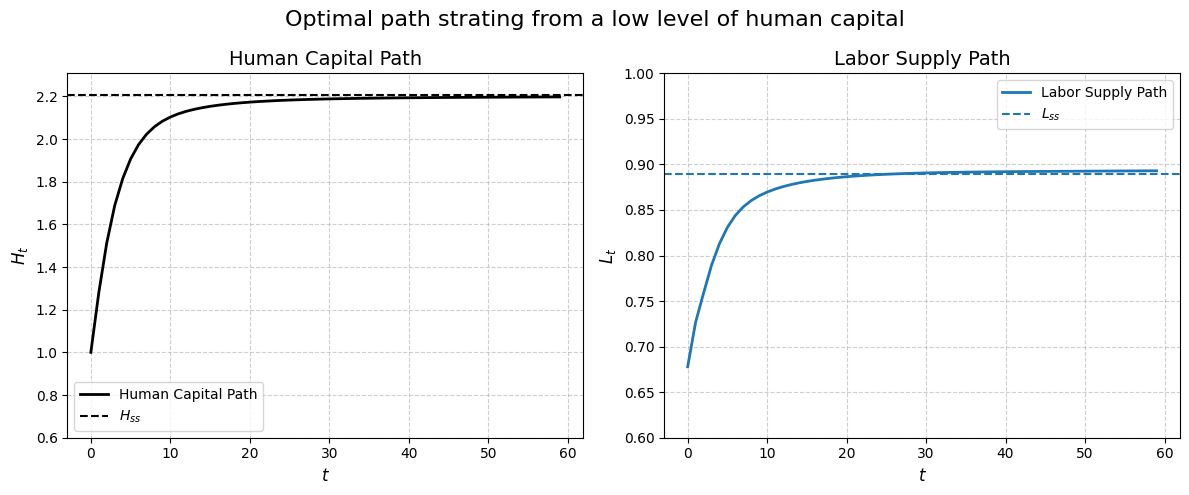

In [150]:
time_test = Grid_data().grid.numpy().flatten()
l_hat_path = optimal_path_initial_low(Grid_data().grid)[:, [0]].detach().numpy().flatten()
h_hat_path = optimal_path_initial_low(Grid_data().grid)[:, [1]].detach().numpy().flatten()

h_ss = SS().h_ss
l_ss = SS().l_ss

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Human Capital Path
axes[0].plot(time_test, h_hat_path, color='black', linewidth=2, label="Human Capital Path")
axes[0].axhline(y=h_ss, linestyle='--', color='black', linewidth=1.5, label=r"$H_{ss}$")
axes[0].set_xlabel(r"$t$", fontsize=12)
axes[0].set_ylabel(r"$H_t$", fontsize=12)
axes[0].set_ylim([0.6, h_ss + 0.1])
axes[0].legend(loc='best', fontsize=10)
axes[0].set_title("Human Capital Path", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Labor Supply Path
axes[1].plot(time_test, l_hat_path, linewidth=2, label="Labor Supply Path")
axes[1].axhline(y=l_ss, linestyle='--', linewidth=1.5, label=r"$L_{ss}$")
axes[1].set_xlabel(r"$t$", fontsize=12)
axes[1].set_ylabel(r"$L_t$", fontsize=12)
axes[1].set_ylim([0.6, max(1.0, l_ss + 0.1)])
axes[1].legend(loc='best', fontsize=10)
axes[1].set_title("Labor Supply Path", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Optimal path strating from a low level of human capital", fontsize=16)
plt.tight_layout()
plt.show()


## 5.5 Path starting from $H_0 > H_{ss} $ 

In [151]:
optimal_path_initial_high = train_neural_network(
    params = Params(),
    train_data=train,
    optimizer=optimizer,
    scheduler=scheduler,
    initial_h=4)

0, Loss: 1.60e+00, Euler: 1.03e-02, H: 7.85e-01, Init: 1.51e+01, LR: 1.00e-03
100, Loss: 2.55e-05, Euler: 2.81e-05, H: 2.56e-05, Init: 4.96e-06, LR: 8.00e-04
200, Loss: 1.72e-05, Euler: 2.07e-05, H: 4.50e-06, Init: 1.90e-06, LR: 6.40e-04
300, Loss: 6.28e-06, Euler: 7.30e-06, H: 3.20e-06, Init: 1.16e-06, LR: 5.12e-04
400, Loss: 6.30e-06, Euler: 4.87e-06, H: 2.32e-05, Init: 8.74e-07, LR: 4.10e-04
500, Loss: 3.93e-06, Euler: 3.30e-06, H: 1.21e-05, Init: 8.04e-07, LR: 3.28e-04
600, Loss: 4.08e-06, Euler: 3.99e-06, H: 8.29e-06, Init: 6.40e-07, LR: 2.62e-04
700, Loss: 1.04e-05, Euler: 1.79e-06, H: 8.90e-05, Init: 8.70e-07, LR: 2.10e-04
800, Loss: 5.97e-06, Euler: 6.30e-06, H: 8.47e-06, Init: 8.30e-07, LR: 1.68e-04
900, Loss: 2.47e-06, Euler: 1.70e-06, H: 1.03e-05, Init: 7.66e-07, LR: 1.34e-04


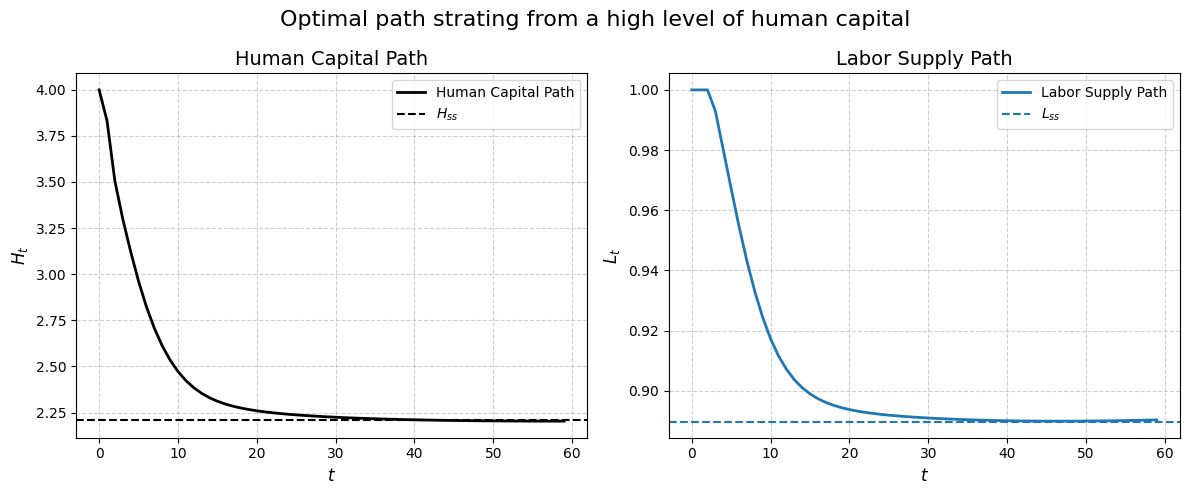

In [152]:
time_test = Grid_data().grid
l_hat_path_high = optimal_path_initial_high(time_test)[:,[0]].detach()
h_hat_path_high = optimal_path_initial_high(time_test)[:,[1]].detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Human Capital Path
axes[0].plot(time_test, h_hat_path_high, color='black', linewidth=2, label="Human Capital Path")
axes[0].axhline(y=h_ss, linestyle='--', color='black', linewidth=1.5, label=r"$H_{ss}$")
axes[0].set_xlabel(r"$t$", fontsize=12)
axes[0].set_ylabel(r"$H_t$", fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].set_title("Human Capital Path", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Labor Supply Path
axes[1].plot(time_test, l_hat_path_high, linewidth=2, label="Labor Supply Path")
axes[1].axhline(y=l_ss, linestyle='--', linewidth=1.5, label=r"$L_{ss}$")
axes[1].set_xlabel(r"$t$", fontsize=12)
axes[1].set_ylabel(r"$L_t$", fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].set_title("Labor Supply Path", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Optimal path strating from a high level of human capital", fontsize=16)
plt.tight_layout()
plt.show()